<div style="background-image:url(fond.jpeg);">
<br>
<br>
<font size="15pt" style="color:#6B86BF">Projet<br><br>Machine Learning</font>
<br>
<br>
<i><font size="3pt" style="color:#3A5989"> Linda DINGUIR<br>
Pierre PAPELARD</font></i>
<br>
<br>
<h1 style="color:#3A5989"> Table des matières</h1><br>
<font size="4pt" style="color:#3A5989">
<ol start="1">
    <li>Présentation de notre jeu de données</li>
    <li>Analyse préliminaire des données</li>
    <li>Encodage des variables catégorielles</li>
    <li>Le choix de notre métrique</li>
    <li>Apprentissage supervisé
        <ol>
            <li>Méthode non paramétriques
                <ol>
                    <li>Méthode des k plus proches voisins</li>
                    <li>Arbre de décision</li>
                    <li>Random forests</li>
                    <li>Adaboost</li>
                    <li>Gradient Boosting</li>
                    <li>XGBoost</li>
                </ol>
            </li>
            <li>Méthode paramétriques</li>
        </ol>
    </li>
    <li>Réseau de neurones</li>
    <li>Conclusion</li>
</ol>
</font>
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, time, itertools
from collections import Counter
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score, brier_score_loss, f1_score, mean_squared_error, recall_score 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from numpy import mean, std
%matplotlib inline

<h2 style="color:#6B86BF">Présentation de notre jeu de données</h2>

Le jeu de données que nous avons choisi provient d'une **campagne de marketing téléphonique** réalisée par une institution bancaire portugaise.<br>
L'objectif de cette campagne était de démarcher les clients afin qu'ils souscrivent à un **dépôt à terme***.<br>
<br>
*Dépot à terme (DAT) : c'est un compte d'épargne qui offre un taux d'intérêt élevé à condition que les sommes déposées soient bloquées pendant un certain temps.

Voici un résumé de notre dataset :<br>
<img src="variables.jpeg" width=60% height=50% style="float:left;"/>

Voici un aperçu du DataFrame :

In [2]:
raw_data = pd.read_csv('bank-additional-full.csv', sep=';').rename(str.title, axis=1)
print ("Le train set contient", len(raw_data), "lignes pour", len(raw_data.columns), "colonnes")
raw_data.head()

Le train set contient 41188 lignes pour 21 colonnes


,Age,Job,Marital,Education,Default,Housing,Loan,Contact,Month,Day_Of_Week,...,Campaign,Pdays,Previous,Poutcome,Emp.Var.Rate,Cons.Price.Idx,Cons.Conf.Idx,Euribor3M,Nr.Employed,Y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


<h2 style="color:#6B86BF">Le choix de notre métrique et problématique</h2>

Comme nous l'avons vu précedement, nous avons affaire à des **données déséquilibrées**. </br>
Nous sommes face à un problème de classification où l’échantillon d’apprentissage contient une forte disparité entre les classes à prédire (**..%** de yes contre **..%** de no).</br>

<i style="color:#5CB27A">Compte tenu de ce déséquilibre, est-il judicieux d'utiliser **l'accuracy** (le taux de bonnes prédictions) ?</i></br>

Imaginons que l'on choisisse un algorithme qui classe chaque exemple dans la classe majoritaire c'est-à-dire qui prédise simplement **"no"** pour tous les individus. Dans ce cas nous auront un taux de bonnes prédictions égale à ..%.</br>
Le modèle semblera performant mais cela ne sera que le reflet de la surreprésentation de la classe majoritaire.</br>

Dans notre cas l'objectif est de prédire si le client va souscrire à un dépôt à terme. C'est donc la classe minoritaire que l’on aimerait pouvoir identifier.

<h2 style="color:#6B86BF">Analyse préliminaire des données</h2>

<h2 style="color:#6B86BF">Encodage des variables catégorielles</h2>

La plupart des algorithmes vus en cours prennent des valeurs numériques en entrée. Il nous faut donc trouver une façon de transformer nos modalités en données numériques. 


Pour ce faire, nous avons choisi d'utiliser les techniques d’encodage suivantes :<br>
- **one-hot encoding** pour les variables : 'Marital', 'Job', 'Loan', 'Housing', 'Education', 'Poutcome', 'Default' et 'Contact' .</br>
- **encodage ordinal** pour les variables 'Month' et 'Day_Of_Week' car elles ont une notion d'ordre. 

In [3]:
data = pd.get_dummies(raw_data,columns=['Marital','Job', 'Loan', 'Housing', 'Education', 'Poutcome', 'Default','Contact'],drop_first=True)
data.Y = data.Y.apply(lambda y :int(y=='yes'))
data['Month']= data['Month'].replace(['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
data['Day_Of_Week']= data['Day_Of_Week'].replace(['mon','tue','wed','thu','fri'],[1, 2, 3, 4, 5])
data.head()

,Age,Month,Day_Of_Week,Duration,Campaign,Pdays,Previous,Emp.Var.Rate,Cons.Price.Idx,Cons.Conf.Idx,...,Education_high.school,Education_illiterate,Education_professional.course,Education_university.degree,Education_unknown,Poutcome_nonexistent,Poutcome_success,Default_unknown,Default_yes,Contact_telephone
0,56,3,1,261,1,999,0,1.1,93.994,-36.4,...,0,0,0,0,0,1,0,0,0,1
1,57,3,1,149,1,999,0,1.1,93.994,-36.4,...,1,0,0,0,0,1,0,1,0,1
2,37,3,1,226,1,999,0,1.1,93.994,-36.4,...,1,0,0,0,0,1,0,0,0,1
3,40,3,1,151,1,999,0,1.1,93.994,-36.4,...,0,0,0,0,0,1,0,0,0,1
4,56,3,1,307,1,999,0,1.1,93.994,-36.4,...,1,0,0,0,0,1,0,0,0,1


<h2 style="color:#6B86BF">Méthode des k plus proches voisins kNN</h2>

Cette approche consiste à étudier les **voisins les plus proches** du point que l'on souhaite prédire.</br> 

On cherche à estimer l'output $y \in \{0 ,1\}$ associé à l'input $X \in \mathbb{R}^d$ en selectionnant $K$ individus dont les inputs sont les plus proches de $X$ dans nos données d'entrainement (X_train).</br>
On entend par "voisins les plus proches" les inividus ayant les **distances** les plus petites de notre input X.</br>


Dans notre problème de classification, on retiendra la classe la plus représentée parmi les $K$ outputs associées aux $K$ inputs les plus proches de la nouvelle entrée $X$.</br>
Ainsi on définit notre classifier $g_n(x)$ tel que :
$$ g_n(X) = \left\{
    \begin{array}{ll}
        1 & \sum_{i = 1}^{k} \frac{1}{k} y_{(i)}(X) > \frac{1}{2} \\
        0 & \mbox{sinon.}
    \end{array}
\right.
$$
où :</br>
$(X_{(1)}(X), y_{(1)}(X)), ..., (X_{(n)}(X), y_{(n)}(X))$ est la permutation des couples $((X_{1}, y_{1}), ..., (X_{n}, y_{n}))$ de X_train de sorte à ce que notre nouvel arrangement soit ordonné de manière à avoir des **distances** croissantes par rapport à notre input X : $||X_j - x||, i.e. ||X_{(1)} - X|| \leq ... \leq ||X_{(n)} - X||$ </br>

Un question que l'on peut se poser est : <i style="color:#5CB27A">Quel **K** allons nous choisir ?</i></br>
On peut aller plus loin et se demander : <i style="color:#5CB27A">Quelle **mesure de distance** reflète le mieux la proximité entre deux variables ?</i></br>

En effet, il existe plusieurs mesures de distance : </br>
**Distance euclidienne** : $ d(X, X') = \sqrt{\sum_{i = 1}^{n} (X_i - X_i')^2} $
</br>
**Distance de Manhattan** : $ d(X, X') = (\sum_{i = 1}^{n} |X_i - X_i'|) $
</br>
**Distance de Minkowski** : $ d(X, X') = (\sum_{i = 1}^{n} |X_i - X_i'|)^{\frac{1}{p}} $
</br>
</br>
$\Longrightarrow$ **K** et la **mesure de distance** sont les deux **hyper-paramètres** de notre modèle.
</br>

<i style="color:#5CB27A">Comment calculer la valeur optimale de nos **hyper-paramètres** ?</i>

$\Longrightarrow$ Nous allons réaliser une **validation-croisée**  afin d'optimiser les hyper-paramètres de l'algorithme.

In [4]:
X = (data.copy()).drop(['Y'], axis=1)
y = data.Y.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [5]:
NumberOfFolds = 5
kf = StratifiedKFold(n_splits=NumberOfFolds, shuffle = True)

In [6]:
hyper_param_grid = {"n_neighbors" : [5, 7, 9, 11, 13, 15, 17, 20], "metric" : ["euclidean", "manhattan", "minkowski"]}

# Creation d'une "GridSearch" à la main : 
# Une liste de liste contenant un classifieur de KNN avec en indice i le nombre de voisins et en j la metrique choisie
clf_grid = []
CV_grid = []
for i in hyper_param_grid["n_neighbors"]:
    tmp_clf = []
    tmp_CV = []
    for j in hyper_param_grid["metric"]:
        clf = KNeighborsClassifier(n_neighbors = i, metric = j)
        tmp_clf.append(clf)
        CV = cross_val_score(clf, X_train, y_train, scoring = 'f1', cv = kf, n_jobs = -1)
        tmp_CV.append(np.mean(CV))
    clf_grid.append(tmp_clf)
    CV_grid.append(tmp_CV)

CV_grid_df = pd.DataFrame(CV_grid, columns = ["Euclidean", "Manhattan", "Minkowski"], index =  [5, 7, 9, 11, 13, 15, 17, 20])
CV_grid_df

,Euclidean,Manhattan,Minkowski
5,0.521714,0.530554,0.525875
7,0.538801,0.525686,0.536116
9,0.538113,0.545853,0.534370
11,0.541595,0.545434,0.544625
13,0.544544,0.549630,0.536205
15,0.541020,0.544193,0.538259
17,0.537769,0.547135,0.547318
20,0.519979,0.524318,0.523029


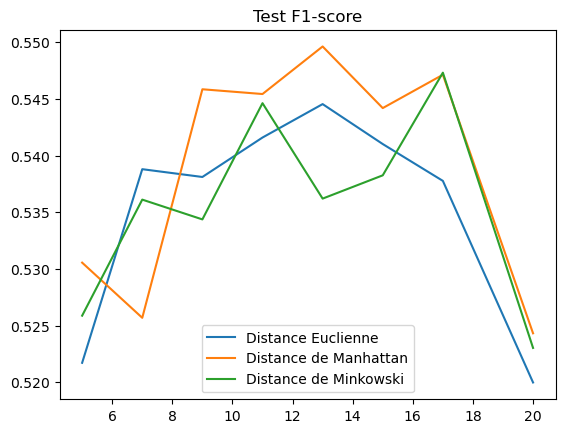

In [7]:
plt.plot([5, 7, 9, 11, 13, 15, 17, 20], CV_grid_df["Euclidean"], label="Distance Euclienne")
plt.plot([5, 7, 9, 11, 13, 15, 17, 20], CV_grid_df["Manhattan"], label="Distance de Manhattan")
plt.plot([5, 7, 9, 11, 13, 15, 17, 20], CV_grid_df["Minkowski"], label="Distance de Minkowski")
plt.legend()
plt.title("Test F1-score")
plt.show()

Au vu des résultats de la **validation croisée** nous avons choisi les hyper-paramètres suivants de sorte à **maximiser** le F1-score de notre modèle:</br>

In [8]:
n = np.argmax(CV_grid)
score = np.array(CV_grid).flatten()[n]
KNN = np.array(clf_grid).flatten()[n]
KNN.fit(X_train, y_train)

print("Nombre de voisons : k = ", hyper_param_grid["n_neighbors"][n//3])
print("Mesure de distance : ", hyper_param_grid["metric"][n%3])
print("Crossval F1-score score : ", score)

Nombre de voisons : k =  13
Mesure de distance :  manhattan
Crossval F1-score score :  0.54962967784982


<h2 style="color:#309784">Phase de prédiction :</h2>

In [9]:
y_pred_KNN = KNN.predict(X_test)
print("Test accuracy : ", KNN.score(X_test, y_test))
print("F1 Score : ", f1_score(y_test, y_pred_KNN))

Test accuracy :  0.910022336602894
F1 Score :  0.5540312876052949


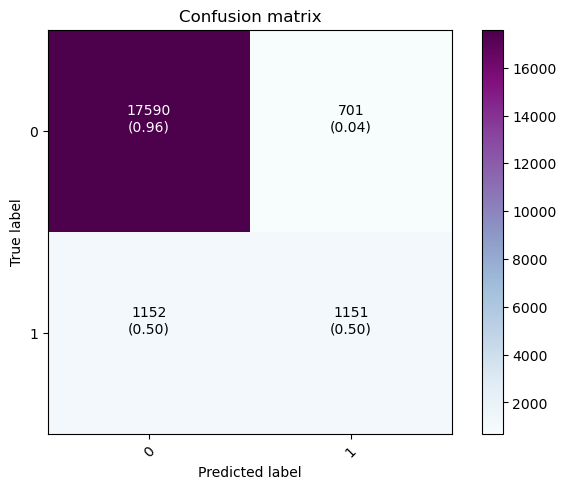

In [10]:
def plot_matrice_confusion(y_test, y_pred):
    CM = confusion_matrix(y_test, y_pred)

    plt.imshow(CM, interpolation='nearest', cmap=plt.cm.BuPu)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_test)))
    plt.xticks(tick_marks, np.unique(y_test), rotation=45)
    plt.yticks(tick_marks, np.unique(y_test))
    thresh = CM.max() / 2.

    for i, j in itertools.product(range(CM.shape[0]), range(CM.shape[1])):
        plt.text(j, i, format(CM[i, j], 'd')+"\n("+format(((CM / CM.sum(axis=1)[:, np.newaxis])[i, j]), '.2f')+")", horizontalalignment="center", color="white" if CM[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_matrice_confusion(y_test, y_pred_KNN)

Près de 96% des clients ne souscrivant pas à un dépôt à terme ont été bien classifié (notre classe majoritaire).<br>
En revanche, seulement la moitié des clients qui souscrivent à un dépôt à terme ont été bien classifié (notre classe minoritaire) ce qui n'est **pas assez satisfaisant**.<br>
On suppose que ces résultats sont dus à la grande **dimensionnalité** de nos données. En effet, la méthode des K plus proches voisins n'est pas très performante en grande dimension: lorsque la dimension est grande tous les points sont **presque équidistants**. $(i.e. \frac{max_{i \neq j}||X_i - X_j||_p}{min_{i \neq j}||X_i - X_j||_p} = 1 + O(\sqrt{\frac{log(n)}{d}}))$<br>

<h2 style="color:#6B86BF">Arbres de décision (CART)</h2>

Le principe de cette méthode est de partitionner l'espace $\mathbb{R}^d$ en plusieurs "cellules" $A_1, A_2,$ ... de telle sorte à expliquer l'output $y$ **par vote majoritaire sa cellule de provenance**.</br>
On définit notre classifier $g_n(X)$ tel que :
$$ g_n(X) = \left\{
    \begin{array}{ll}
        1 & \sum_{i = 1}^{k} \mathbb{1}_{X_i \in A(X)}\mathbb{1}_{Y_i = 1} > \sum_{i = 1}^{k} \mathbb{1}_{X_i \in A(X)}\mathbb{1}_{Y_i = 0} \\
        0 & \mbox{sinon.}
    \end{array}
\right.
$$
où :</br>

<i style="color:#5CB27A">Quel est la profondeur optimale de l'arbre ?</i></br>
<i style="color:#5CB27A">Quel critère allons nous utiliser ?</i></br>
A finir ... 

In [11]:
hyper_param_grid = {"max_depth" : np.arange(2, 15), "critere" : ["gini", "entropy"]}

clf_grid = []
CV_grid = []
for i in hyper_param_grid["max_depth"]:
    tmp_clf = []
    tmp_CV = []
    for j in hyper_param_grid["critere"]:
        clf = DecisionTreeClassifier(max_depth = i, criterion = j)
        tmp_clf.append(clf)
        CV = cross_val_score(clf, X_train, y_train, scoring = 'f1', cv = kf, n_jobs = -1)
        tmp_CV.append(np.mean(CV))
    clf_grid.append(tmp_clf)
    CV_grid.append(tmp_CV)

CV_grid_df = pd.DataFrame(CV_grid, columns = ["Gini", "Entropy"], index =  np.arange(2, 15))
CV_grid_df

,Gini,Entropy
2,0.489948,0.494885
3,0.588200,0.546617
4,0.561077,0.569989
5,0.554790,0.563009
6,0.559500,0.529140
7,0.562616,0.566531
8,0.555157,0.545240
9,0.532237,0.561019
10,0.555852,0.541889
11,0.542466,0.526313


Text(0, 0.5, 'Score F1')

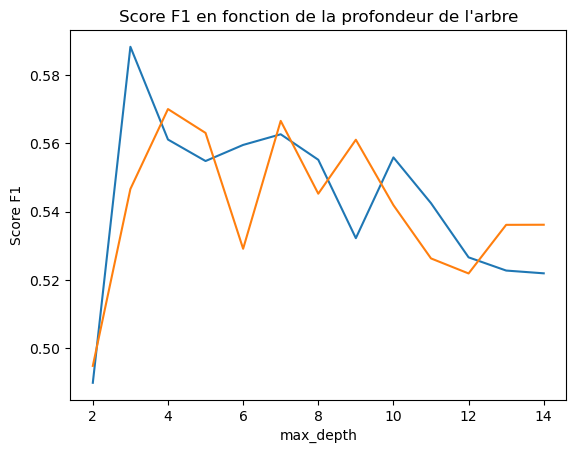

In [12]:
plt.plot(np.arange(2, 15), CV_grid_df["Gini"], label="Critère de Gini")
plt.plot(np.arange(2, 15), CV_grid_df["Entropy"], label="Critère d'Entropy")

plt.title("Score F1 en fonction de la profondeur de l'arbre")
plt.xlabel("max_depth")
plt.ylabel("Score F1")

Les **hyper-paramètres optimaux** :

Profondeur maximale de l'arbre :  3
critère :  gini
Crossval F1-score score :  0.588200201433332


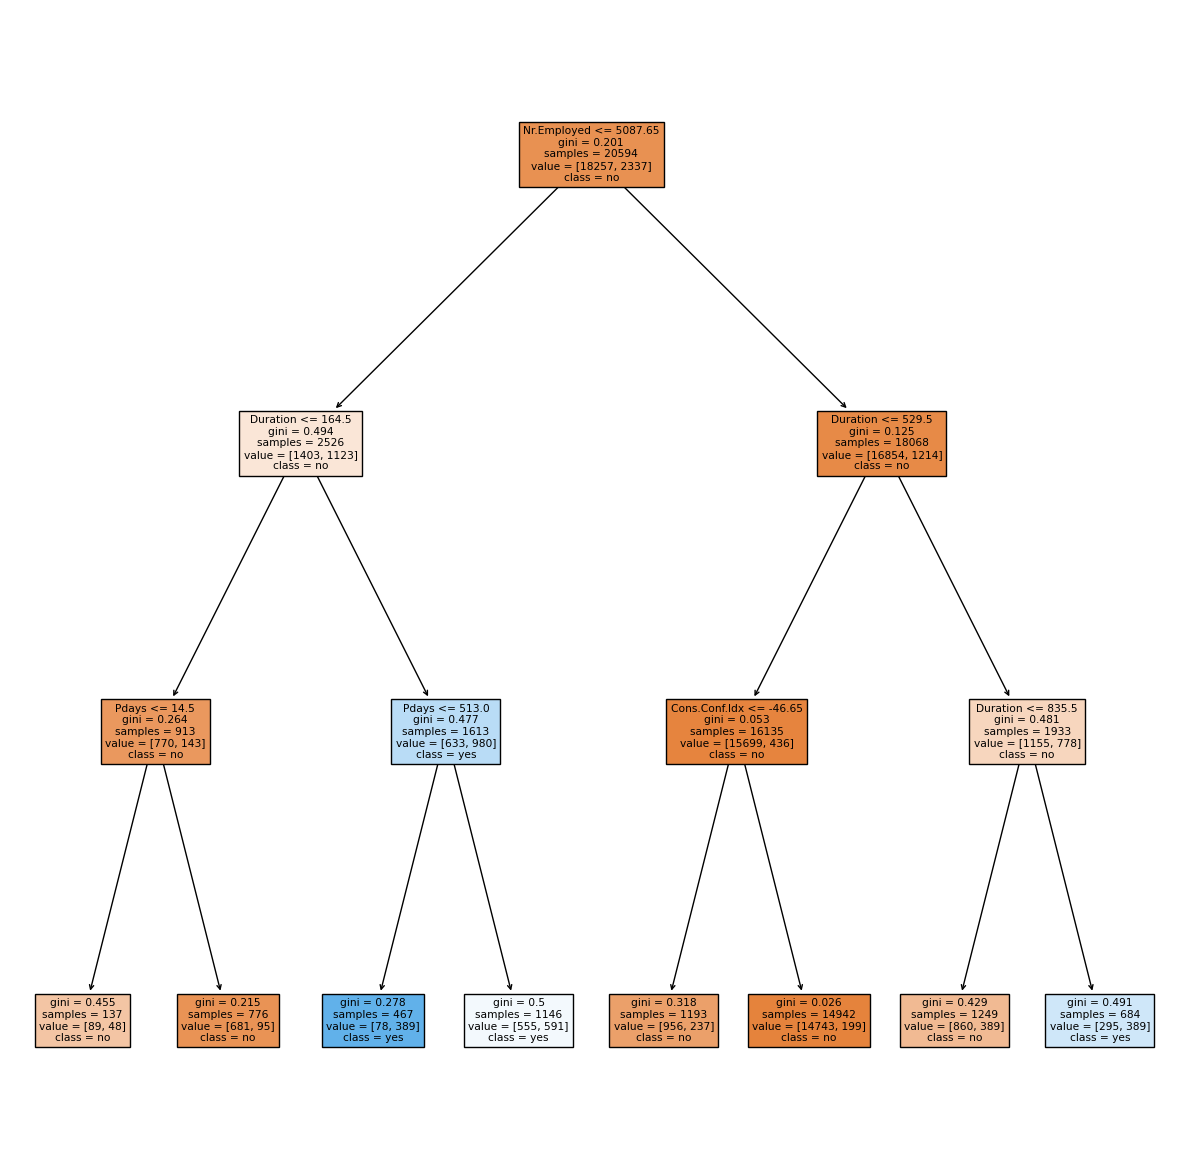

In [13]:
n = np.argmax(CV_grid)
score = np.array(CV_grid).flatten()[n]
TREE = np.array(clf_grid).flatten()[n]
TREE.fit(X_train, y_train)

print("Profondeur maximale de l'arbre : ", hyper_param_grid["max_depth"][n//2])
print("critère : ", hyper_param_grid["critere"][n%2])
print("Crossval F1-score score : ", score)

plt.figure(figsize=(15,15))
tree.plot_tree(TREE, filled = True, class_names=['no', 'yes'], feature_names=X.columns) # A verifier si jene me suis pas trompee de sens dans yes et no
plt.show()

<h2 style="color:#309784">Phase de prédiction :</h2>

In [14]:
y_pred_TREE = TREE.predict(X_test)

print("Test accuracy : ", TREE.score(X_test, y_test))
print("F1 Score : ", f1_score(y_test, y_pred_TREE))

Test accuracy :  0.9092454112848403
F1 Score :  0.5921885228016582


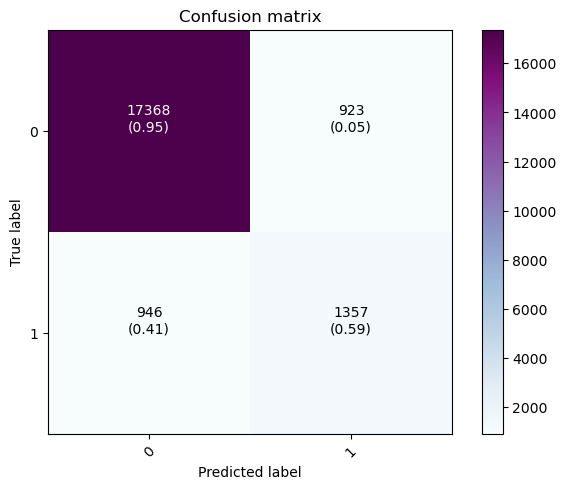

In [15]:
plot_matrice_confusion(y_test, y_pred_TREE)

On obtient des résultats légèrement meilleurs qu'avec la méthode des K plus proches voisins.<br>
On commence à voir se dessiner la case des **vrais positifs** sur la matrice de confusion: c'est-à-dire que notre algorithme commence à cibler les clients qui souscrivent à un DAT. 

<h1 style="color:#6B86BF">Random forests</h1>

Une **Random Forest** (Forêt d'arbres de décision) est une technique qui fait partie des **méthodes d'ensemble**. Elle qui combine :<br>
- **Les arbres de décision**<br>
- **Le Bagging**<br>

*Le principe* : Au lieu d'entrainer un seul arbre (comme nous l'avons fait à la section précédente), nous allons entrainer plusieurs arbres **différents** (constitués de sous-ensembles d'individus et de variables séléctionnés aléatoirement) de telle sorte à réduire la corréaltion entre les arbres. Le **résultat final** est obtenu par **vote majoritaire** de tous les arbres de décision.<br>

C’est l’assemblage de tous ces arbres ("**weak learners**") qui rend extrêmement performante la prédiction.
<img src="RandomForest.pdf" width=800 height="500"/>
Le **bagging** implique la sélection d'échantillons bootstrap à partir de l'ensemble de données d'entraînement afin de réduire la corrélation entre les arbres.<br>
Lors de l'apprentissage de **données déséquilibrées**, il y a de fortes chances qu'un échantillon bootstrap contienne peu ou même pas d'individus de la classe minoritaire, ce qui donne un arbre peu performant pour la prédiction de la classe minoritaire.<br>
Pour cela, nous allons utiliser le paramètre **class_weight='balanced'** qui permet de changer le poids de chaque classe lors du calcul du score d'impureté. Cela permet de placer une pénalité plus lourde sur le mauvais classement de la classe minoritaire.

In [16]:
RF_params = {"max_depth" : np.arange(2, 30), "n_estimators": [10, 50, 100, 200]}

clf_grid = []
CV_grid = []
for i in RF_params["max_depth"]:
    tmp_clf = []
    tmp_CV = []
    for j in RF_params["n_estimators"]:
        clf = RandomForestClassifier(n_estimators=j, max_depth = i, class_weight='balanced')
        tmp_clf.append(clf)
        CV = cross_val_score(clf, X_train, y_train, scoring = 'f1', cv = kf, n_jobs = -1)
        tmp_CV.append(np.mean(CV))
    clf_grid.append(tmp_clf)
    CV_grid.append(tmp_CV)

CV_grid_df = pd.DataFrame(CV_grid, columns = ["10", "50", "100", "200"], index =  np.arange(2, 30))
CV_grid_df

,10,50,100,200
2,0.453223,0.441872,0.460079,0.449242
3,0.500339,0.461682,0.478214,0.468341
4,0.493210,0.514328,0.502469,0.524605
5,0.528611,0.529356,0.541898,0.541856
6,0.547722,0.557988,0.563671,0.561997
7,0.565228,0.571900,0.574625,0.572704
8,0.572467,0.582212,0.584165,0.585565
9,0.589770,0.597182,0.596993,0.598729
10,0.593159,0.611584,0.606691,0.610802
11,0.592183,0.615717,0.619412,0.620220


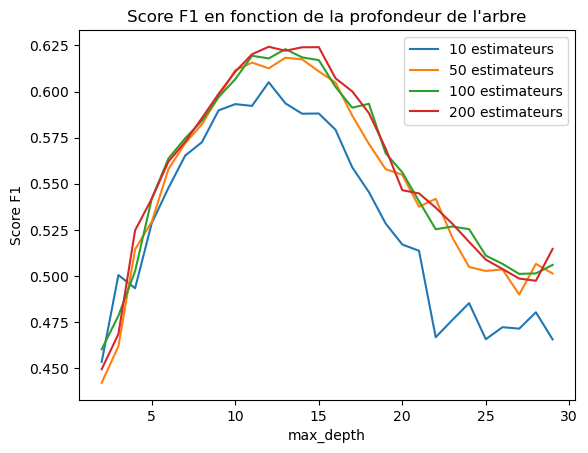

In [17]:
plt.plot(np.arange(2, 30), CV_grid_df["10"], label="10 estimateurs")
plt.plot(np.arange(2, 30), CV_grid_df["50"], label="50 estimateurs")
plt.plot(np.arange(2, 30), CV_grid_df["100"], label="100 estimateurs")
plt.plot(np.arange(2, 30), CV_grid_df["200"], label="200 estimateurs")

plt.title("Score F1 en fonction de la profondeur de l'arbre")
plt.xlabel("max_depth")
plt.ylabel("Score F1")
plt.legend()
plt.show()

Les **hyper-paramètres optimaux** :

In [18]:
n = np.argmax(CV_grid)
score = np.array(CV_grid).flatten()[n]
RF = np.array(clf_grid, dtype=object).flatten()[n]
RF.fit(X_train, y_train)

print("Profondeur maximale de l'arbre : ", RF_params["max_depth"][n//4])
print("Nombre d'estimateurs : ", RF_params["n_estimators"][n%4])
print("Crossval F1-score score : ", score)
print("Test accuracy : ", RF.score(X_train, y_train))

Profondeur maximale de l'arbre :  12
Nombre d'estimateurs :  200
Crossval F1-score score :  0.6242877053798581
Test accuracy :  0.9128872487132175


<h2 style="color:#309784">Phase de prédiction :</h2>

In [19]:
y_pred_RF = RF.predict(X_test)
print("Test accuracy : ", RF.score(X_test, y_test))
print("F1 Score : ", f1_score(y_test, y_pred_RF))

Test accuracy :  0.8843352432747402
F1 Score :  0.6220247540463345


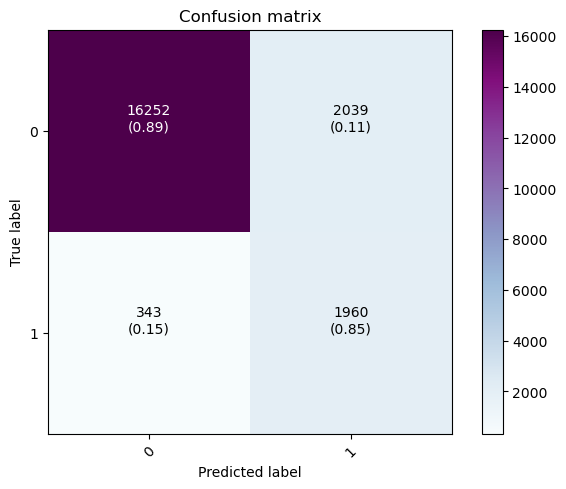

In [20]:
plot_matrice_confusion(y_test, y_pred_RF)

Nous avons réussi à classer 86% de la classe minoritaire.<br>
$\Longrightarrow$ On commence enfin à bien cibler les future detenteurs d'un DAT.<br> 
En contrepartie on observe une **légère augmentation des faux positifs** pour la classe majoritaire.<br>
Ce qui nous donne un **F1-score** de 0.622.

<h1 style="color:#6B86BF">Boosting</h1>

Dans cette partie nous allons voir une autre **méthode d'ensemble** : le **boosting**.<br>
<br>
Cette fois-ci, les algorithmes ne sont plus indépendants comme pour la Random Forest, au contraire, chaque "weak learner" est entrainé pour **corriger les erreurs** du "weak learner" précédent.<br>
<img src="boosting.png" width=800 height="500"/>
La prncipale différence entre l'algoritme Adaboost et Gradient boosting est la façon dont ils déterminent les **lacunes** des weak learners : le boosting travaille de manière **séquentielle**.

<h2 style="color:#6B86BF">Adaboost</h2>

L'algorithme **Adaboost** commence par attribuer des **poids égaux** à toutes les observations de notre jeu de données d'entrainement.<br>
À partir des résultats de notre premier arbre de décision (notre weak learner), le poids des individus **mal classifiés** se voit augmenter et à l'inverse le poids des individus **bien classifiés** se voit **diminuer**.<br>
Chaque weak learner corrige donc les erreurs faites par les précédents. Le fait de corriger les poids au fur et à mesure permet de mieux prédire les valeurs difficiles.


In [21]:
ada_params = {"n_estimators" : [10, 50, 100, 200], "learning_rate" : [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0]}

ada_grid = GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), param_grid=ada_params, cv=kf, scoring = 'f1')

# Entrainement du classifier
ada_grid.fit(X_train, y_train)

score_grid = pd.DataFrame(ada_grid.cv_results_['mean_test_score'].reshape(7, 4), columns = ["10", "50", "100", "200"], index =  [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0])
score_grid

,10,50,100,200
0.01,0.495496,0.498794,0.491035,0.492133
0.05,0.497293,0.501327,0.492141,0.497629
0.10,0.501407,0.496739,0.493093,0.497949
0.50,0.499312,0.494011,0.493700,0.492060
1.00,0.498058,0.495165,0.494741,0.491710
1.50,0.492774,0.500572,0.496706,0.497290
2.00,0.499029,0.493442,0.497618,0.493930


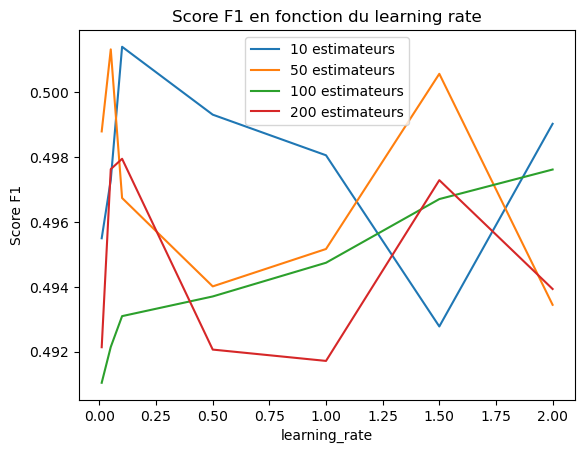

In [22]:
plt.plot([0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0], score_grid["10"], label="10 estimateurs")
plt.plot([0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0], score_grid["50"], label="50 estimateurs")
plt.plot([0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0], score_grid["100"], label="100 estimateurs")
plt.plot([0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0], score_grid["200"], label="200 estimateurs")

plt.title("Score F1 en fonction du learning rate")
plt.xlabel("learning_rate")
plt.ylabel("Score F1")
plt.legend()
plt.show()

Les **hyper-paramètres optimaux** :

In [23]:
print("Learning rate optimal : ", ada_grid.best_params_['learning_rate'])
print("Nombre d'estimateurs : ", ada_grid.best_params_['n_estimators'])
print("Crossval F1-score : ", ada_grid.best_score_)
print("Test accuracy : ", ada_grid.score(X_train, y_train))

Learning rate optimal :  0.1
Nombre d'estimateurs :  10
Crossval F1-score :  0.5014070030264887
Test accuracy :  1.0


<h2 style="color:#309784">Phase de prédiction :</h2>

In [24]:
y_pred_ada = ada_grid.predict(X_test)
print("F1 Score : ", f1_score(y_test, y_pred_ada))
print("Test accuracy : ", accuracy_score(y_test, y_pred_ada))

F1 Score :  0.5147430497051391
Test accuracy :  0.8881227542002526


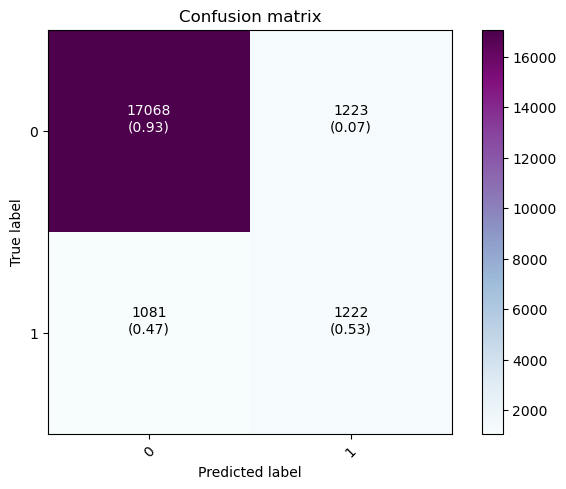

In [25]:
plot_matrice_confusion(y_test, y_pred_ada)

L'Adaboost est peu performant sur notre jeu de données.<br>
Nos résultats sont à peine mieux que ceux des K plus proches voisins.<br>
En effet, on avoisine les 50% de bonnes classifications pour la classe minoritaire ce qui n'est pas très performant. 

<h2 style="color:#6B86BF">Gradient boosting</h2>

Plutôt que d'attribuer des poids à nos observations afin de corriger les erreurs du weak learner précédent, nous allons minimiser la fonction de coût afin de minimiser les erreurs liées aux prévisions.<br>
Parler plus ... 

In [26]:
gb_params = {"n_estimators" : [10, 50, 100, 200], "learning_rate" : [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0]}


gb_grid = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=gb_params, cv=kf, scoring = 'f1')

gb_grid.fit(X_train, y_train)

score_grid = pd.DataFrame(gb_grid.cv_results_['mean_test_score'].reshape(7, 4), columns = ["10", "50", "100", "200"], index =  [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0])
score_grid

,10,50,100,200
0.01,0.000000,0.000000,0.263634,0.459319
0.05,0.000000,0.513214,0.566686,0.574547
0.10,0.292155,0.568831,0.571555,0.575208
0.50,0.573947,0.568283,0.570219,0.569651
1.00,0.533292,0.547660,0.550262,0.545630
1.50,0.508899,0.509410,0.508818,0.508503
2.00,0.532916,0.525418,0.525418,0.525418


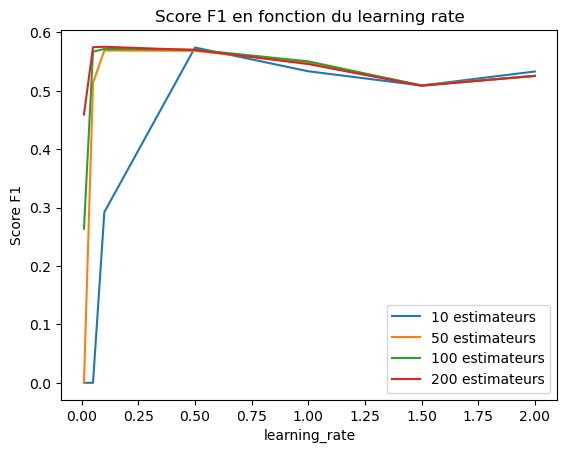

In [27]:
plt.plot([0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0], score_grid["10"], label="10 estimateurs")
plt.plot([0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0], score_grid["50"], label="50 estimateurs")
plt.plot([0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0], score_grid["100"], label="100 estimateurs")
plt.plot([0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0], score_grid["200"], label="200 estimateurs")

plt.title("Score F1 en fonction du learning rate")
plt.xlabel("learning_rate")
plt.ylabel("Score F1")
plt.legend()
plt.show()

Les **hyper-paramètres optimaux** :

In [28]:
print("Learning rate optimal : ", gb_grid.best_params_['learning_rate'])
print("Nombre d'estimateurs : ", gb_grid.best_params_['n_estimators'])
print("Crossval F1-score : ", gb_grid.best_score_)
print("Test accuracy : ", gb_grid.score(X_train, y_train))

Learning rate optimal :  0.1
Nombre d'estimateurs :  200
Crossval F1-score :  0.57520802198404
Test accuracy :  0.6503156872268091


<h2 style="color:#309784">Phase de prédiction :</h2>

In [29]:
y_pred_GB = gb_grid.predict(X_test)
print("F1 Score : ", f1_score(y_test, y_pred_GB))
print("Test accuracy : ", accuracy_score(y_test, y_pred_GB))

F1 Score :  0.6050863723608445
Test accuracy :  0.9200738079052151


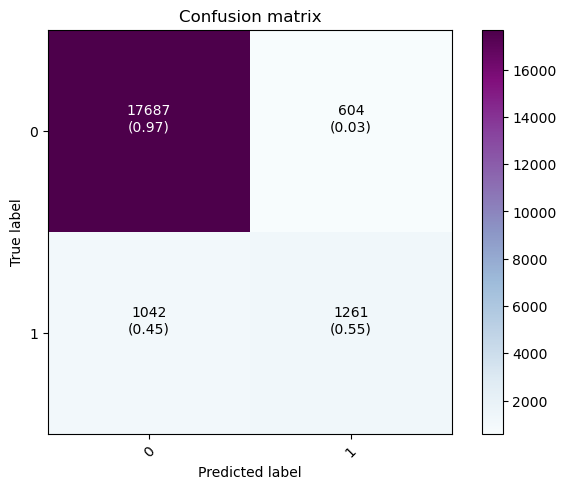

In [30]:
plot_matrice_confusion(y_test, y_pred_GB)

$\Longrightarrow$ On obtient des résultats assez similaire à ceux de l'Adaboost.

<h2 style="color:#6B86BF">Extreme Gradient Boosting (XGBoost)</h2>

XGBoost, abréviation de Extreme Gradient Boosting, est une mise en œuvre plus performante de l'algorithme du Gradient Boosting présenté à la section précédente.<br>
Présentation de XGBoost, ...<br>
Cet algorithme nous est très utile car il offre un moyen de régler un **hyperparamètre** afin  accorder plus d'attention aux erreurs de classification de la **classe minoritaire** pour les ensembles de données avec une distribution de classe **très déséquilibrée** : il s'agit de l'hyperparamètre **scale_pos_weight**.<br>
La valeur de **scale_pos_weight** permet de mettre à l'échelle le **gradient** en faveur de la **classe positive** (classe minoritaire) ce qui nous donne une version de XGBoost pondérée par classe.<br>
Afin d'obtenir des résultats optimaux, nous allons ajuster cet hypermaramètre à l'aide d'une GridSearch :

In [31]:
xgb_params = {"learning_rate" : [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0], "scale_pos_weight" : np.arange(2, 22, 2)}

xgb_grid = GridSearchCV(estimator=XGBClassifier(nthread = -1), param_grid=xgb_params, cv=kf, scoring = 'f1')

# Entrainement du classifier
xgb_grid.fit(X_train, y_train)

xgb_score_grid = pd.DataFrame(xgb_grid.cv_results_['mean_test_score'].reshape(10, 7), columns = ["0.01", "0.05", "0.1", "0.5", "1.0", "1.5", "2.0"], index =  np.arange(2, 22, 2))
xgb_score_grid

,0.01,0.05,0.1,0.5,1.0,1.5,2.0
2,0.624423,0.613855,0.591544,0.577071,0.564909,0.554959,0.547208
4,0.542230,0.538656,0.533644,0.634472,0.631034,0.617856,0.599428
6,0.583587,0.573472,0.564863,0.560034,0.554780,0.551939,0.636317
8,0.630287,0.623065,0.612238,0.594669,0.588467,0.586772,0.577888
10,0.572927,0.568969,0.585923,0.598336,0.598879,0.605165,0.598015
12,0.603822,0.602729,0.600573,0.602813,0.608002,0.560459,0.569461
14,0.569827,0.575648,0.569817,0.585207,0.565953,0.577643,0.581889
16,0.572310,0.555619,0.562266,0.556380,0.562416,0.552555,0.557114
18,0.571027,0.559652,0.554314,0.550445,0.429740,0.370522,0.320946
20,0.369466,0.315432,0.284588,0.236075,0.296869,0.393435,0.307060


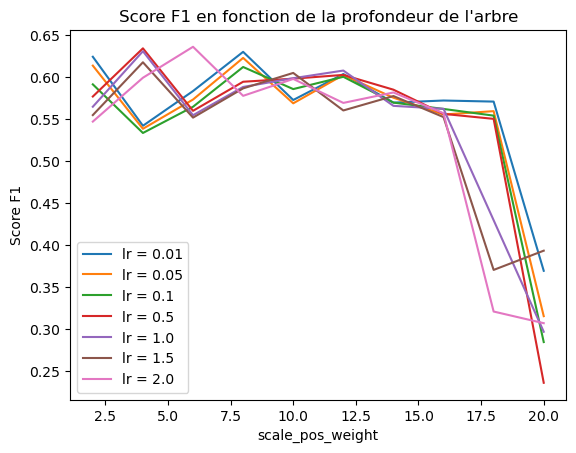

In [32]:
plt.plot(np.arange(2, 22, 2), xgb_score_grid["0.01"], label="lr = 0.01")
plt.plot(np.arange(2, 22, 2), xgb_score_grid["0.05"], label="lr = 0.05")
plt.plot(np.arange(2, 22, 2), xgb_score_grid["0.1"], label="lr = 0.1")
plt.plot(np.arange(2, 22, 2), xgb_score_grid["0.5"], label="lr = 0.5")
plt.plot(np.arange(2, 22, 2), xgb_score_grid["1.0"], label="lr = 1.0")
plt.plot(np.arange(2, 22, 2), xgb_score_grid["1.5"], label="lr = 1.5")
plt.plot(np.arange(2, 22, 2), xgb_score_grid["2.0"], label="lr = 2.0")

plt.title("Score F1 en fonction de la profondeur de l'arbre")
plt.xlabel("scale_pos_weight")
plt.ylabel("Score F1")
plt.legend()
plt.show()

Les **hyper-paramètres optimaux** :

In [33]:
print("Learning rate optimal : ", xgb_grid.best_params_['learning_rate'])
print("scale_pos_weight optimal : ", xgb_grid.best_params_['scale_pos_weight'])
print("Crossval F1-score : ", xgb_grid.best_score_)
print("Test accuracy : ", xgb_grid.score(X_train, y_train))

Learning rate optimal :  0.1
scale_pos_weight optimal :  2
Crossval F1-score :  0.636316608352766
Test accuracy :  0.7493739163937584


<h2 style="color:#309784">Phase de prédiction :</h2>

In [34]:
y_pred_xg = xgb_grid.predict(X_test)
print("F1 Score : ", f1_score(y_test, y_pred_xg))
print("Test accuracy : ", accuracy_score(y_test, y_pred_xg))

F1 Score :  0.6544246923227193
Test accuracy :  0.9141011945226765


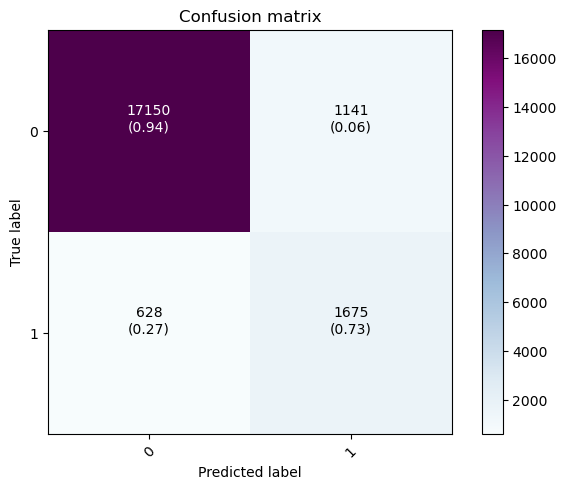

In [35]:
plot_matrice_confusion(y_test, y_pred_xg)

On voit que l'algorithme arrive à plutôt bien classifié les clients qui souscrivent à un dépot à terme.<br>
On obtient de bien meilleurs résultats que les méthodes de boosting présentées juste avant.<br>
Mais les résultats ne sont pas aussi pérformant que la Random Forest. 

<h2 style="color:#6B86BF">Conclusion</h2>

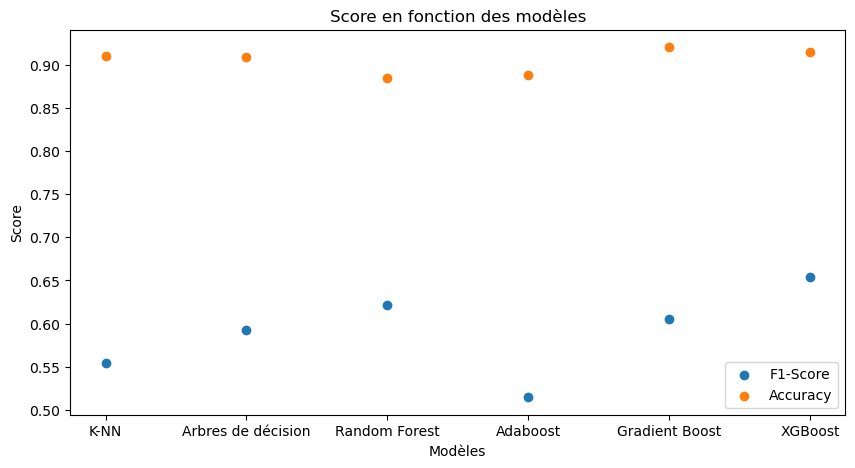

In [46]:
plt.figure(figsize=(10,5))
plt.scatter(["K-NN", "Arbres de décision", "Random Forest", "Adaboost", "Gradient Boost", "XGBoost"], [f1_score(y_test, y_pred_KNN), f1_score(y_test, y_pred_TREE), f1_score(y_test, y_pred_RF), f1_score(y_test, y_pred_ada), f1_score(y_test, y_pred_GB), f1_score(y_test, y_pred_xg)], label="F1-Score")
plt.scatter(["K-NN", "Arbres de décision", "Random Forest", "Adaboost", "Gradient Boost", "XGBoost"], [accuracy_score(y_test, y_pred_KNN), accuracy_score(y_test, y_pred_TREE), accuracy_score(y_test, y_pred_RF), accuracy_score(y_test, y_pred_ada), accuracy_score(y_test, y_pred_GB), accuracy_score(y_test, y_pred_xg)], label="Accuracy")
plt.title("Score en fonction des modèles")
plt.xlabel("Modèles")
plt.ylabel("Score")
plt.legend()
plt.show()

In [ ]:
# Rajouter les resultats des autres algos et Commenter 